In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sc
import cupyx.scipy.sparse as sparse
from cupyx.scipy.sparse.linalg import eigsh
import scipy.special as special
import cupyx.scipy.special as special_cp
import time
import os


h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.602e-19
phi0 = h/(2*e)
phi0bar = phi0/(2*np.pi)
gap = 0.00017*e # from Kittel
Zq = phi0bar/(2*e)
kb = 1.38e-23

In [3]:
def normalize(v):
    norm = cp.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm


def matel(x, i, j):
    n = min(i, j)
    m = max(i, j)
    factor = (-0.5)**((m-n)/2.) \
            *1./np.sqrt(special.poch(n+1,m-n)) \
            *x**(m-n) \
            *np.exp(-0.25*x**2) \
            *special.eval_genlaguerre(n, m-n, 0.5*x**2)
    return factor


def cosx(p, i, j):
    if (i-j)%2 == 0:
        return matel(np.sqrt(2)*p, i, j)
    else:
        return 0
    
    
def sinx(p, i, j):
    if (i-j)%2 == 1:
        comp = -1j*matel(np.sqrt(2)*p, i, j)
        if abs(np.imag(comp)) > 1e-10:
            raise ValueError("Matrix element is complex")
        else:
            return np.real(comp)
    else:
        return 0
    
    
def progress(pos, tot):
    if pos % int(tot/10) == 0:
        print('.', end='')
        
        
def cap(EC):
    EC = EC*1e9*h
    return e**2/(2*EC)


def ind(EL):
    EL = EL*1e9*h
    return phi0bar**2/EL


def enc(C):
    C = C*1e9*h
    return e**2/(2*C)


def enl(L):
    L = L*1e9*h
    return phi0bar**2/L


def phizpf(L, C):
    EL = enl(L)
    EC = enc(C)
    return (2*EC/EL)**0.25


def Nzpf(L, C):
    EL = enl(L)
    EC = enc(C)
    return 0.5*(0.5*EL/EC)**0.25

def matrices_f_sparse(dim, params):
    
    FOCK = dim[2]
    EC, EL = params[0], params[2]
    ECf, ELf = 0.5*EC, 2*EL
    zpf = phizpf(ind(ELf), cap(ECf))
    
    COS = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    SIN = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    for i in range(FOCK):
        for j in range(FOCK):
            COS[i,j] += cosx(zpf, i, j)
            SIN[i,j] += sinx(zpf, i, j)
    COSsparse = sparse.dia_matrix(sc.sparse.dia_array(COS))
    SINsparse = sparse.dia_matrix(sc.sparse.dia_array(SIN))
    
    return COSsparse, SINsparse


def matrices_r_sparse(dim, params):
    
    fock = dim[1]
    EC, EL = params[0], params[2]
    ECf, ELf = 0.5*EC, 2*EL
    zpf = phizpf(ind(ELf), cap(ECf))
    
    COS = np.zeros((fock,fock), dtype=np.cfloat)
    SIN = np.zeros((fock,fock), dtype=np.cfloat)
    for i in range(fock):
        for j in range(fock):
            COS[i,j] += cosx(zpf, i, j)
            SIN[i,j] += sinx(zpf, i, j)
    COSsparse = sparse.dia_matrix(sc.sparse.dia_array(COS))
    SINsparse = sparse.dia_matrix(sc.sparse.dia_array(SIN))
    
    return COSsparse, SINsparse


def Nsigma_op(dim, params):  #eta operator
    
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECr, ELr = 0.5*EC, 2*EL
    Qr = cp.zeros((fock,fock), dtype=cp.cfloat)
    for i in range(fock):
        for j in range(fock):
            if i == j-1:
                Qr[i,j] -= 1j*0.5*(ELr/(2*ECr))**0.25*cp.sqrt(j)
            elif i == j+1:
                Qr[i,j] += 1j*0.5*(ELr/(2*ECr))**0.25*cp.sqrt(i)
                
    return cp.kron(cp.eye(Nc),cp.kron(Qr, cp.eye(FOCK)))


def Ndelta_op(dim,params):
    
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    ECf, ELf = 0.5*EC, 2*EL
    Qf = cp.zeros((FOCK,FOCK), dtype=cp.cfloat)
    for i in range(FOCK):
        for j in range(FOCK):
            if i == j-1:
                Qf[i,j] -= 1j*0.5*(ELf/(2*ECf))**0.25*cp.sqrt(j)
            elif i == j+1:
                Qf[i,j] += 1j*0.5*(ELf/(2*ECf))**0.25*cp.sqrt(i)
                
    return cp.kron(cp.eye(Nc),cp.kron(cp.eye(fock), Qf))


def N_op(dim, params, ng): 
    
    DIM, fock, FOCK = dim
    Nc = 2*DIM+1
    EC, EJ, EL, y, dC, dJ, dL = params
    Qc = cp.zeros((Nc,Nc), dtype=cp.cfloat)  
    for i in range(Nc):
        I = i-DIM
        Qc[i,i] += I-ng
        
    return cp.kron(Qc,cp.kron(cp.eye(fock),cp.eye(FOCK)))


def _Hamiltonian2_sparse(dim, ng, params, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse): #r: phisigma / f: phidelta
    
    DIM, fock, FOCK = dim
    EC, EJ, EL, y, dC, dJ, dL = params
    Nc = 2*DIM+1
    ECc, ECr, ECf = y*EC, 0.5*EC, 0.5*EC
    ELr, ELf = 2*EL, 2*EL
    
    Qc = np.zeros((Nc,Nc), dtype=np.cfloat)
    COSc = np.zeros((Nc,Nc), dtype=np.cfloat)
    SINc = np.zeros((Nc,Nc), dtype=np.cfloat)
    Hr = np.zeros((fock,fock), dtype=np.cfloat)
    Qr = np.zeros((fock,fock), dtype=np.cfloat)
    Fr = np.zeros((fock,fock), dtype=np.cfloat)
    Hf = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    Qf = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    Ff = np.zeros((FOCK,FOCK), dtype=np.cfloat)
    for i in range(Nc):
        I = i-DIM
        Qc[i,i] += I-ng
        for j in range(Nc):
            if i == j-1:
                COSc[i,j] += 0.5
                SINc[i,j] += +0.5*1j
            elif i == j+1:
                COSc[i,j] += 0.5
                SINc[i,j] += -0.5*1j
                
    for i in range(fock):
        Hr[i,i] += np.sqrt(8*ECr*ELr)*i
        for j in range(fock):
            if i == j-1:
                Qr[i,j] -= 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(j)
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(j)
            elif i == j+1:
                Qr[i,j] += 1j*0.5*(ELr/(2*ECr))**0.25*np.sqrt(i)
                Fr[i,j] += (2*ECr/ELr)**0.25*np.sqrt(i)
                
    for i in range(FOCK):
        Hf[i,i] += np.sqrt(8*ECf*ELf)*i
        for j in range(FOCK):
            if i == j-1:
                Qf[i,j] -= 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(j)
                Ff[i,j] += (2*ECf/ELf)**0.25*np.sqrt(j)
            elif i == j+1:
                Qf[i,j] += 1j*0.5*(ELf/(2*ECf))**0.25*np.sqrt(i)
                Ff[i,j] += (2*ECf/ELf)**0.25*cp.sqrt(i)
                
    Qc_sparse = sparse.dia_matrix(sc.sparse.dia_array(Qc))
    Qr_sparse = sparse.dia_matrix(sc.sparse.dia_array(Qr))
    Qf_sparse = sparse.dia_matrix(sc.sparse.dia_array(Qf))
    Fr_sparse = sparse.dia_matrix(sc.sparse.dia_array(Fr))
    Ff_sparse = sparse.dia_matrix(sc.sparse.dia_array(Ff))
    Hr_sparse = sparse.dia_matrix(sc.sparse.dia_array(Hr))
    Hf_sparse = sparse.dia_matrix(sc.sparse.dia_array(Hf))
    COSc_sparse = sparse.dia_matrix(sc.sparse.dia_array(COSc))
    SINc_sparse = sparse.dia_matrix(sc.sparse.dia_array(SINc))
    #diagonal terms
    H0 = 4 * ECc * sparse.kron(Qc_sparse@Qc_sparse, sparse.eye(fock*FOCK)) \
        + sparse.kron(sparse.eye(Nc), sparse.kron(Hr_sparse, sparse.eye(FOCK))) \
        + sparse.kron(sparse.eye(Nc*fock), Hf_sparse) \
        + 4 * ECc * sparse.kron(sparse.eye(Nc), sparse.kron(Qr_sparse@Qr_sparse, sparse.eye(FOCK)))
    #capacitive coupling terms
    H1 = + 8 * ECc * sparse.kron(Qc_sparse, sparse.kron(Qr_sparse, sparse.eye(FOCK))) \
            - 2* dC * sparse.kron(sparse.eye(Nc), sparse.kron(Qr_sparse, Qf_sparse))
    #inductive coupling terms
    H2 = + dL * sparse.kron(sparse.eye(Nc), sparse.kron(Fr_sparse, Ff_sparse))
    #junction terms that go with cos(phiext/2)
    H3 = - 2 * EJ * (sparse.kron(COSc_sparse, sparse.kron(COSr_sparse, COSf_sparse)) + sparse.kron(SINc_sparse, sparse.kron(SINr_sparse, COSf_sparse))) \
             + dJ *( sparse.kron(SINc_sparse, sparse.kron(COSr_sparse, SINf_sparse)) - sparse.kron(COSc_sparse, sparse.kron(SINr_sparse, SINf_sparse)))
    #junction terms that go with sin(phiext/2)
    H4 = + 2 * EJ * (sparse.kron(COSc_sparse, sparse.kron(COSr_sparse, SINf_sparse)) + sparse.kron(SINc_sparse, sparse.kron(SINr_sparse, SINf_sparse))) \
                    + dJ *( sparse.kron(SINc_sparse, sparse.kron(COSr_sparse, COSf_sparse)) - sparse.kron(COSc_sparse, sparse.kron(SINr_sparse, COSf_sparse)))
    return H0 + H1 + H2, H3, H4


def Hamiltonian_sparse(H, phiext):
    return H[0] + cp.cos(phiext/2)*H[1] + cp.sin(phiext/2)*H[2]


def first_n_states_sparse(ham,n_cutoff,dim): #dim = [charge, fock, fock]
    ev = cp.zeros(n_cutoff,dtype=cp.cfloat)
    evec = cp.zeros(((2*dim[0]+1)*dim[2]*dim[1], n_cutoff),dtype=cp.cfloat)
    ev, evec = eigsh(ham, k=n_cutoff, which='SA', return_eigenvectors=True)
    return ev, evec


def off_diagonal(states,op,ii,jj):
    psi0 = states[:,ii]
    psi1 = states[:,jj]
    return cp.vdot(psi1,cp.dot(op,psi0))

In [4]:
def cpu(x):
    if cp.get_array_module(x).__name__ == 'cupy':
        return x.get()
    else:
        return x


def gpu(x):
    if cp.get_array_module(x).__name__ == 'numpy':
        return x
    else:
        return cp.array(x)


def parser(E, precision=2):
    E = cpu(E)
    E_int = int(E)
    E_dec = int(np.round((E-np.floor(E_int))*10**precision))
    E_int_str = str(E_int)
    E_dec_str = str(E_dec)
    for ii in range(1, precision):
        if E_dec < 10 ** (precision - ii):
            E_dec_str = '0' + E_dec_str
    Eparsed = '%sp%s' % (E_int_str, E_dec_str)
    return Eparsed


def namer(EC, EJ, EL, ECs, precisions=[2,2,2,2]):
    EC = parser(cpu(EC), precision=precisions[0])
    EJ = parser(cpu(EJ), precision=precisions[1])
    EL = parser(cpu(EL), precision=precisions[2])
    ECs = parser(cpu(ECs), precision=precisions[3])
    name = 'EC%s_EJ%s_EL%s_ECS%s' % (EC, EJ, EL, ECs)
    return name


bare_params = [3.7, cp.array(5.01), 0.41, 0.002]
namer(*bare_params)

'EC3p70_EJ5p01_EL0p41_ECS0p00'

In [5]:
# single set of param vs phi and ng

bare_params = [2.56, 2.90, 0.41, 0.1]   # EC, EJ, EL, ECshunt

folder = os.getcwd()
directory = os.path.join(folder, namer(*bare_params)+'_asym5_CuPy')
if not os.path.exists(directory):
    os.makedirs(directory)

ngs = cp.array([0.5])
phiexts = cp.linspace(-cp.pi, 0, 51)

dim_n = 15   # charge basis \pm dim_n, actual dimension is 2*dim_n+1
dim_phisigma = 25   # harmonic oscillator basis
dim_phidelta = 25   # harmonic oscillator basis
dim = [dim_n, dim_phisigma, dim_phidelta]
Hsize = (2*dim_n+1)*dim_phisigma*dim_phidelta

EC, EJ, EL, ECshunt = bare_params
y = ECshunt/EC
dJ = 0.05*EJ
dC = -0.05*EJ   # DL 1st order in dJ/Ej
dL = 0

params = [EC, EJ, EL, y, dC, dJ, dL]
np.save(os.path.join(directory, 'params'), np.array(params), allow_pickle=True)

COSr_sparse, SINr_sparse = matrices_r_sparse(dim, params)
COSf_sparse, SINf_sparse = matrices_f_sparse(dim, params)
coupling_op = N_op(dim, params, ng=0) + Nsigma_op(dim, params)
n_cutoff = 50
for ii, ng in enumerate(ngs):
    lvls = cp.zeros((phiexts.size, n_cutoff), dtype='complex')
    # states = cp.zeros((phiexts.size, Hsize, n_cutoff), dtype='complex')
    matelts = cp.zeros((phiexts.size, n_cutoff, n_cutoff), dtype='complex')
    _H = _Hamiltonian2_sparse(
        dim, ng, params, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse)

    t0 = time.time()
    print('ng %i/%i' % (ii+1, ngs.size))
    for jj, phiext in enumerate(phiexts):

        H = Hamiltonian_sparse(_H, phiext)
        ev, evec = first_n_states_sparse(H, n_cutoff, dim)
        lvls[jj] = ev
        # states[jj] = evec
        matelts[jj] = (evec.T.conj() @ coupling_op @ evec)[:n_cutoff, :n_cutoff]

    if ng < 0.1:
        name = 'vs_phiext_ng_0p0%i' % (ng*100)
    else:
        name = 'vs_phiext_ng_0p%i' % (ng*100)
    np.save(os.path.join(directory, name),
            np.array([ngs.get(), phiexts.get(), lvls.get(), matelts.get()],
                     dtype='object'),
            allow_pickle=True)
    print('%is - saved file: %s' % (time.time() - t0, directory + '/' + name))
    print('--------')



ng 1/1
104s - saved file: /workspace/kitemon_ovh/EC2p56_EJ2p90_EL0p41_ECS0p10_asym5_CuPy/vs_phiext_ng_0p50
--------


In [4]:
# single set of param vs ng @ phi

bare_params = [2.56, 2.90, 0.41, 0.1]   # EC, EJ, EL, ECshunt

folder = os.getcwd()
directory = os.path.join(folder, namer(*bare_params)+'_asym5_CuPy')
if not os.path.exists(directory):
    os.makedirs(directory)

ngs = cp.linspace(0,1,41)
phiext = 0

dim_n = 15   # charge basis \pm dim_n, actual dimension is 2*dim_n+1
dim_phisigma = 25   # harmonic oscillator basis
dim_phidelta = 25   # harmonic oscillator basis
dim = [dim_n, dim_phisigma, dim_phidelta]
Hsize = (2*dim_n+1)*dim_phisigma*dim_phidelta

EC, EJ, EL, ECshunt = bare_params
y = ECshunt/EC
dJ = 0.05*EJ
dC = -0.05*EJ   # DL 1st order in dJ/Ej
dL = 0

params = [EC, EJ, EL, y, dC, dJ, dL]
np.save(os.path.join(directory, 'params'), np.array(params), allow_pickle=True)

COSr_sparse, SINr_sparse = matrices_r_sparse(dim, params)
COSf_sparse, SINf_sparse = matrices_f_sparse(dim, params)
coupling_op = N_op(dim, params, ng=0) + Nsigma_op(dim, params)
n_cutoff = 50
lvls = cp.zeros((ngs.size, n_cutoff), dtype='complex')
matelts = cp.zeros((ngs.size, n_cutoff, n_cutoff), dtype='complex')
t0 = time.time()
for ii, ng in enumerate(ngs):
    print('ng %i/%i' % (ii+1, ngs.size))
    _H = _Hamiltonian2_sparse(
        dim, ng, params, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse)

    H = Hamiltonian_sparse(_H, phiext)
    ev, evec = first_n_states_sparse(H, n_cutoff, dim)
    lvls[ii] = ev
    matelts[ii] = (evec.T.conj() @ coupling_op @ evec)[:n_cutoff, :n_cutoff]

    print('%is' % (time.time() - t0))
    
name = 'vs_ng_phiext_%.2f' % (phiext)
np.save(os.path.join(directory, name),
        np.array([ngs.get(), phiext, lvls.get(), matelts.get()],
                 dtype='object'),
        allow_pickle=True)
print('--------')



ng 1/41
3s
ng 2/41
6s
ng 3/41
8s
ng 4/41
10s
ng 5/41
12s
ng 6/41
15s
ng 7/41
19s
ng 8/41
22s
ng 9/41
24s
ng 10/41
26s
ng 11/41
28s
ng 12/41
31s
ng 13/41
33s
ng 14/41
35s
ng 15/41
39s
ng 16/41
42s
ng 17/41
44s
ng 18/41
46s
ng 19/41
48s
ng 20/41
51s
ng 21/41
53s
ng 22/41
55s
ng 23/41
58s
ng 24/41
60s
ng 25/41
62s
ng 26/41
64s
ng 27/41
70s
ng 28/41
72s
ng 29/41
74s
ng 30/41
76s
ng 31/41
79s
ng 32/41
81s
ng 33/41
83s
ng 34/41
85s
ng 35/41
90s
ng 36/41
93s
ng 37/41
95s
ng 38/41
97s
ng 39/41
99s
ng 40/41
102s
ng 41/41
104s


NameError: name 'phiexts' is not defined

In [5]:
name = 'vs_ng_phiext_%.2f' % (phiext)
np.save(os.path.join(directory, name),
        np.array([ngs.get(), phiext, lvls.get(), matelts.get()],
                 dtype='object'),
        allow_pickle=True)
print('--------')

--------


In [5]:
# sweep around some initial params

bare_params = [2.84, 3.22, 0.42, 0.1]   # EC, EJ, EL, ECshunt

folder = os.getcwd()
subfolder = os.path.join(folder, namer(*bare_params))
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

variations = [0.1, 0.1, 0.1, 0.05]   # wplasma, EJ/EC, EL, ECshunt

# ngs = cp.linspace(0.0, 0.5, 11)
ngs = cp.array([0.25])
phiexts = cp.linspace(-cp.pi, 0, 51)

dim_n = 15   # charge basis \pm dim_n, actual dimension is 2*dim_n+1
dim_phisigma = 25   # harmonic oscillator basis
dim_phidelta = 25   # harmonic oscillator basis
dim = [dim_n, dim_phisigma, dim_phidelta]
Hsize = (2*dim_n+1)*dim_phisigma*dim_phidelta

for vv, variation in enumerate(variations):
    print('----------------')
    print('variation %i' % vv)
    print('----------------')
    if vv==0:
        scales = [1 - variation, 1, 1 + variation]
    else:
        scales = [1 - variation, 1 + variation]    
    for scale in scales:
        if vv == 0:   # wplasma sweep
            EC = cp.array(bare_params[0] * scale)
            EJ = cp.array(bare_params[1] * scale)
            EL = cp.array(bare_params[2])
            ECshunt = cp.array(bare_params[3])
        elif vv == 1:   # EJ/EC sweep
            EC = cp.array(bare_params[0] / np.sqrt(scale))   # if not cupy, it will compute on cpu
            EJ = cp.array(bare_params[1] * np.sqrt(scale))
            EL = cp.array(bare_params[2])
            ECshunt = cp.array(bare_params[3])
        elif vv == 2:   # EL sweep
            EC = cp.array(bare_params[0])
            EJ = cp.array(bare_params[1])
            EL = cp.array(bare_params[2] * scale)
            ECshunt = cp.array(bare_params[3])
        elif vv == 3:   # ECshunt sweep
            EC = cp.array(bare_params[0])
            EJ = cp.array(bare_params[1])
            EL = cp.array(bare_params[2])
            ECshunt = cp.array(bare_params[3] * scale)
        y = ECshunt/EC
        dJ = 0.05*EJ
        dC = -0.05*EJ   # DL 1st order in dJ/Ej
        dL = 0

        params_gpu = [EC, EJ, EL, y, dC, dJ, dL]
        params_cpu = [cpu(EC), cpu(EJ), cpu(EL), cpu(y), cpu(dC), cpu(dJ), cpu(dL)]

        dir_name = namer(EC, EJ, EL, ECshunt, precisions=[2,2,2,3])+'_asym5_CuPy'
        directory = os.path.join(subfolder, dir_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        np.save(os.path.join(directory, 'params'), np.array(params_cpu), allow_pickle=True)

        COSr_sparse, SINr_sparse = matrices_r_sparse(dim, params_cpu)
        COSf_sparse, SINf_sparse = matrices_f_sparse(dim, params_cpu)
        coupling_op = N_op(dim, params_gpu, ng=0) + Nsigma_op(dim, params_gpu)
        n_cutoff = 50
        for ii, ng in enumerate(ngs):
            lvls = cp.zeros((phiexts.size, n_cutoff), dtype='complex')
            # states = cp.zeros((phiexts.size, Hsize, n_cutoff), dtype='complex')
            matelts = cp.zeros((phiexts.size, n_cutoff, n_cutoff), dtype='complex')
            _H = _Hamiltonian2_sparse(dim, ng, params_gpu, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse)
        
            t0 = time.time()
            print('ng %i/%i'%(ii+1, ngs.size))
            for jj, phiext in enumerate(phiexts):
                
                H = Hamiltonian_sparse(_H, phiext)
                ev, evec = first_n_states_sparse(H, n_cutoff, dim)
                lvls[jj] = ev
                # states[jj] = evec
                matelts[jj] = (evec.T.conj() @ coupling_op @ evec)[:n_cutoff,:n_cutoff]

            if ng < 0.1:
                name = 'vs_phiext_ng_0p0%i'%(ng*100)
            else:
                name = 'vs_phiext_ng_0p%i'%(ng*100)
            np.save(os.path.join(directory, name), 
                    np.array([ngs.get(), phiexts.get(), lvls.get(), matelts.get()], dtype='object'), 
                    allow_pickle=True)
            # print('%is - saved file: %s'%(time.time()-t0, dir_name+'/'+name)) 
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            print(current_time, ' - saved file: %s'%(dir_name+'/'+name))
            print('--------')
print('over')


----------------
variation 0
----------------
ng 1/1
16:20:02  - saved file: EC2p56_EJ2p90_EL0p42_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
ng 1/1
16:21:41  - saved file: EC2p84_EJ3p22_EL0p42_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
ng 1/1
16:23:19  - saved file: EC3p12_EJ3p54_EL0p42_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
----------------
variation 1
----------------
ng 1/1
16:24:57  - saved file: EC2p99_EJ3p05_EL0p42_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
ng 1/1
16:26:35  - saved file: EC2p71_EJ3p38_EL0p42_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
----------------
variation 2
----------------
ng 1/1
16:28:22  - saved file: EC2p84_EJ3p22_EL0p38_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
ng 1/1
16:30:02  - saved file: EC2p84_EJ3p22_EL0p46_ECS0p100_asym5_CuPy/vs_phiext_ng_0p25
--------
----------------
variation 3
----------------
ng 1/1
16:31:40  - saved file: EC2p84_EJ3p22_EL0p42_ECS0p095_asym5_CuPy/vs_phiext_ng_0p25
--------
ng 1/1
16:33:24  - saved

In [10]:
0.11*0.95

0.1045

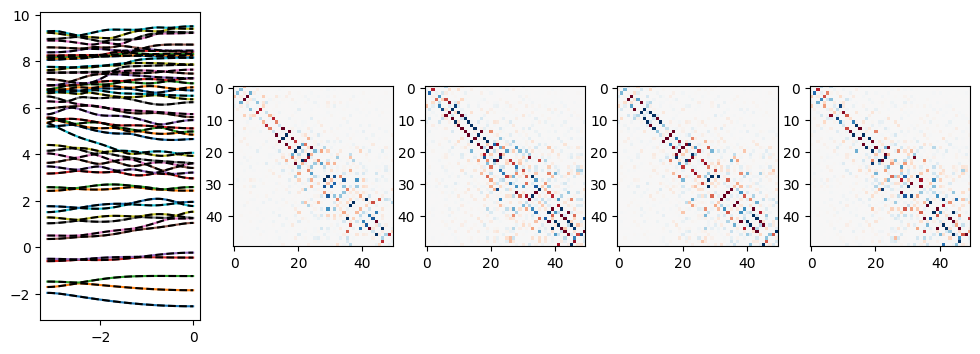

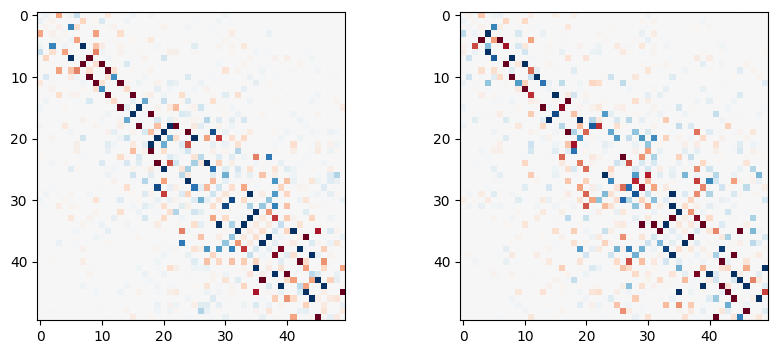

In [85]:
# comparing results
folder = os.path.join(os.getcwd(), 'EC3p7_EJ5p01_EL0p41_ECs0p10_asym5_CuPy')
name = 'vs_phiext_ng_0p0.npy'
n, p, l, m = np.load(os.path.join(folder,name),
                     allow_pickle=True)
folder = os.path.join(os.getcwd(), 'EC3p7_EJ5p01_EL0p41_ECs0p10_asym5')
name = 'vs_phiext_ng_0p0.npy'
_n, _p, _l, _m = np.load(os.path.join(folder,name),
                     allow_pickle=True)

fig, ax = plt.subplots(1,5,figsize=(12,4))
_ = ax[0].plot(p, l)
_ = ax[0].plot(_p, _l, c='k', ls='--')

pp = 0
vmin, vmax = -1, 1
ax[1].imshow((m[pp]).real, vmin=vmin, vmax=vmax, cmap='RdBu')
ax[2].imshow((m[pp]).imag, vmin=vmin, vmax=vmax, cmap='RdBu')
ax[3].imshow((_m[pp]).real, vmin=vmin, vmax=vmax, cmap='RdBu')
ax[4].imshow((_m[pp]).imag, vmin=vmin, vmax=vmax, cmap='RdBu')
# ax[3].imshow((_m[pp]).real, vmin=vmin, vmax=vmax, cmap='RdBu')
# ax[4].imshow((_m[pp]).imag, vmin=vmin, vmax=vmax, cmap='RdBu')
# ax.set_ylim([2,5])

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow((m[pp]-_m[pp]).real, vmin=vmin, vmax=vmax, cmap='RdBu')
ax[1].imshow((m[pp]-_m[pp]).imag, vmin=vmin, vmax=vmax, cmap='RdBu')


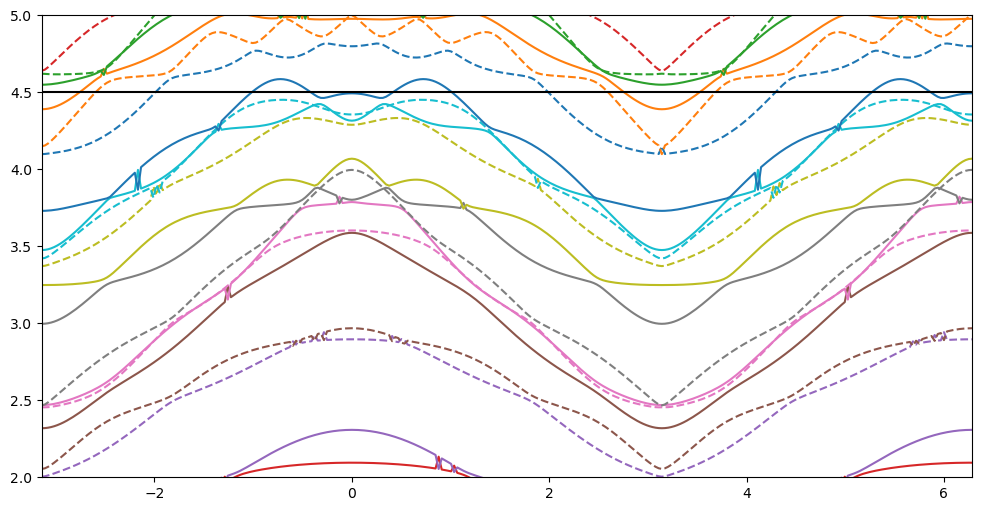

In [141]:
nrjs = lvls - lvls[:,:,0][:,:,None]
phiexts2 = np.concatenate((phiexts, phiexts[1:]+2*np.pi))
nrjs2 = np.concatenate((nrjs, nrjs[:,1:,:]), axis=1)
ncut = 15
fig, ax = plt.subplots(figsize=(12,6))
for ll in range(ncut):
    _ = ax.plot(phiexts2, nrjs2[0,:,ll].real, c='C%i'%ll)
    _ = ax.plot(phiexts2, nrjs2[1,:,ll].real, ls='--', c='C%i'%ll)
ax.set_ylim([2,5])
ax.set_xlim([-np.pi,2*np.pi])
ax.axhline(4.5, c='k')

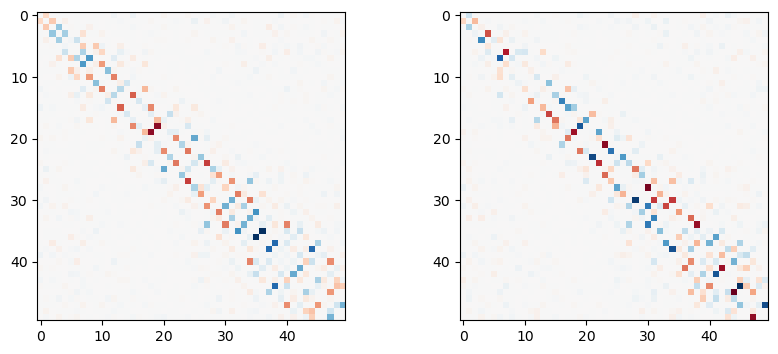

In [79]:
ii, jj = 0, 1
matelt = matelts[ii,jj] - np.diag(matelts[ii,jj].diagonal())
vmin = min([matelt.real.min(), matelt.imag.min()])
vmax = max([matelt.real.max(), matelt.imag.max()])
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(matelt.real, vmin=vmin, vmax=vmax, cmap='RdBu')
ax[1].imshow(matelt.imag, vmin=vmin, vmax=vmax, cmap='RdBu')

In [25]:
def lines_vs_phi(EC, EJ, EL, ECs, phiexts, ng=0.25, number=[4,5,7,8,10]):
    dim_n = 15   # charge basis \pm dim_n, actual dimension is 2*dim_n+1
    dim_phisigma = 25   # harmonic oscillator basis
    dim_phidelta = 25   # harmonic oscillator basis
    dim = [dim_n, dim_phisigma, dim_phidelta]

    y = ECs/EC
    dJ = 0.05*EJ
    dC = -0.05*EJ  
    dL = 0
    params = [EC, EJ, EL, y, dC, dJ, dL]

    COSr_sparse, SINr_sparse = matrices_r_sparse(dim, params)
    COSf_sparse, SINf_sparse = matrices_f_sparse(dim, params)
    n_cutoff = 50

    lvls = cp.zeros((phiexts.size, n_cutoff), dtype='complex')
    _H = _Hamiltonian2_sparse(
        dim, ng, params, COSr_sparse, SINr_sparse, COSf_sparse, SINf_sparse)
    for jj, phiext in enumerate(phiexts):
        H = Hamiltonian_sparse(_H, phiext)
        ev, _ = first_n_states_sparse(H, n_cutoff, dim)
        lvls[jj] = ev
    lines = lvls - lvls[:,0][:,None]
    number = 1+np.array(number)
    return np.real(lines.get()[:,number])

In [26]:
EC = 2.15
EJ = 4.25
EL = 0.4
ECs = 0.11
phiexts = cp.linspace(-cp.pi, 0, 21)

lines = lines_vs_phi(EC, EJ, EL, ECs, phiexts)

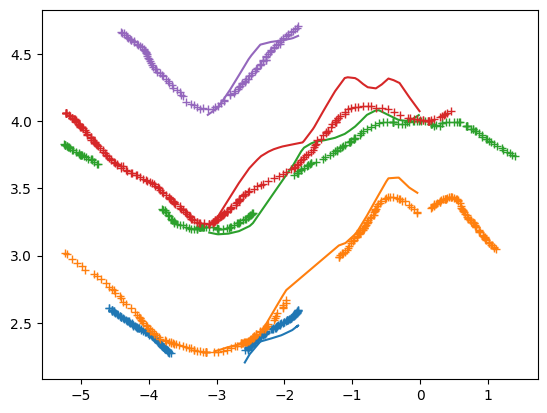

In [36]:
folder = os.path.join(os.getcwd(), 'data_240313')

fig, ax = plt.subplots()
for nn, number in enumerate([4,5,7,8,10]):
    phi_exp, line_exp = np.load(os.path.join(folder, 'line%i.npy'%number), allow_pickle=True)
    ax.plot(phi_exp, line_exp, '+', c='C%i'%nn)
    
    fline = sc.interpolate.interp1d(phiexts.get(), lines.T[nn])
    phi_exp = phi_exp[phi_exp > phiexts.get()[0]]
    phi_exp = phi_exp[phi_exp < phiexts.get()[-1]]
    ax.plot(phi_exp, fline(phi_exp), '-', c='C%i'%nn)
    

In [29]:
lines[nn]

array([1.83492188, 2.27322832, 3.17399412, 3.20040894, 4.04332359])